In [2]:
###-----------------
### Import Libraries
###-----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf



In [3]:
###----------------
# Global Variables
###----------------


TEST_SIZE = 0.2
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)


N_SAMPLES = 1000
NOISE = 0.2
ALPHA = 0.1
EPOCHS = 1000

# set location of input files and output files
inpDir = '../input'
outDir = '../output'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
###-----------------------------------------------------------
### Function to plot Loss Curve using Tensorflow history object
###------------------------------------------------------------

def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(), 
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


---
$$
\textbf{Make Moon Dataset}
$$

In [5]:
X,y = datasets.make_moons(
        n_samples = N_SAMPLES,
        noise = NOISE,
        shuffle  = True,
        random_state = RANDOM_STATE
)
X.shape, y.shape

((1000, 2), (1000,))

<Axes: xlabel='A', ylabel='B'>

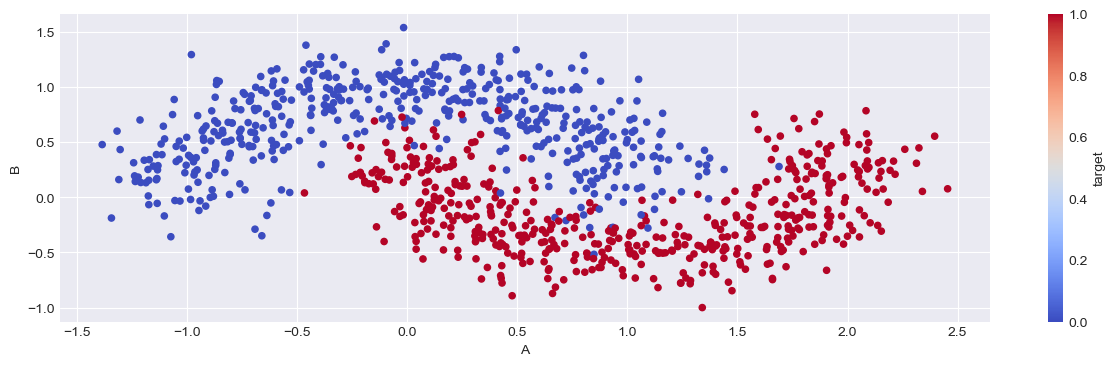

In [6]:
data_df = pd.DataFrame(X, columns = ('A','B'))
data_df['target'] = y
data_df.head()

data_df.plot.scatter('A','B',c= 'target', cmap=CMAP)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,stratify = y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [7]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,), name = 'input'), # input layer
    tf.keras.layers.Dense(5, activation = 'relu', name = 'fc_1'),
    tf.keras.layers.Dense(5, activation = 'relu',  name = 'fc_2'),
    tf.keras.layers.Dense(4, activation = 'relu', name = 'fc_3'),
    tf.keras.layers.Dense(3, activation = 'relu',  name = 'fc_4'),
    tf.keras.layers.Dense(2, name = 'output')
    
])

In [9]:
prediction = model(X_train[:1]).numpy()
prediction.sum()

0.015455094

In [ ]:
tf.nn.softmax(prediction).numpy().sum()

1.0

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                    │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92 (368.00 B)

 Trainable params: 92 (368.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.utils.plot_model(
    model, 
    "My_first_model.png",
    show_shapes = True,show_dtype=True,
    show_layer_names = True
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [13]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [14]:
loss_fn(y_train[:1], prediction).numpy()

0.70965934

In [ ]:
model.compile(optimizer = 'adam',
    loss = loss_fn,
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    x = X_train,
    y =  y_train, 
    validation_data = [X_test, y_test],
    epochs=EPOCHS
) 


Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6118 - loss: 0.6734 - val_accuracy: 0.8050 - val_loss: 0.6657
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8432 - loss: 0.6620 - val_accuracy: 0.8300 - val_loss: 0.6541
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8525 - loss: 0.6466 - val_accuracy: 0.8200 - val_loss: 0.6396
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8533 - loss: 0.6249 - val_accuracy: 0.8250 - val_loss: 0.6213
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8495 - loss: 0.6085 - val_accuracy: 0.8250 - val_loss: 0.6003
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.5930 - val_accuracy: 0.8200 - val_loss: 0.5778
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8611 - loss: 0.5595 - val_accuracy: 0.8200 - val_loss: 0.5533
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8494 - loss: 0.5438 - val_accuracy: 0

In [18]:
hist_df = pd.DataFrame(history.history) #Dictionary
display(hist_df.head())

,accuracy,loss,val_accuracy,val_loss
0,0.71250,0.670008,0.805,0.665678
1,0.84500,0.657623,0.830,0.654073
2,0.84125,0.643803,0.820,0.639596
3,0.84625,0.626762,0.825,0.621300
4,0.85000,0.606469,0.825,0.600265


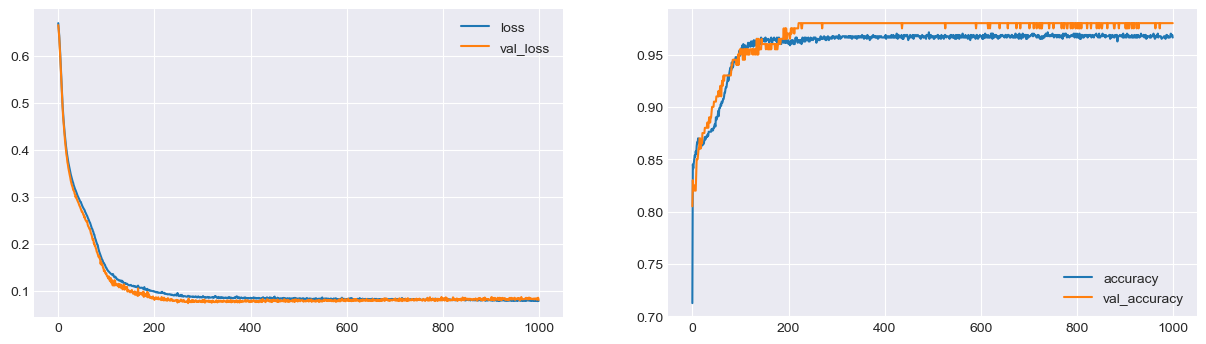

In [19]:
fig, axes = plt.subplots(1,2)
hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])
plt.show()